# Dynamic FBA

In [1]:
%run 2.Ecoli_model.ipynb

Putrescine
ptrc_p
Putrescine
ptrc_c
Putrescine
ptrc_e
9.56477064220183
N-Acetyl-L-glutamate 5-semialdehyde
acg5sa_c
N2-Succinyl-L-glutamate 5-semialdehyde
sucgsa_c
L-Glutamate 5-semialdehyde
glu5sa_c
Ornithine
orn_e
Ornithine
orn_p
Ornithine
orn_c
2-Oxoglutarate
akg_e
2-Oxoglutarate
akg_c
2-Oxoglutarate
akg_p
L-Glutamate 1-semialdehyde
glu1sa_c
L-Glutamate
glu__L_c
L-Glutamate 5-semialdehyde
glu5sa_c
L-Glutamate
glu__L_e
L-Glutamate
glu__L_p
L-Glutamate 5-phosphate
glu5p_c
glu5sa_c + glu__L_c --> akg_c + orn_c
53.02333333333343
9.92914285714283
L-Arginine
arg__L_c
L-Arginine
arg__L_e
L-Arginine
arg__L_p
Urea CH4N2O
urea_c
Urea CH4N2O
urea_p
Urea CH4N2O
urea_e
H2O H2O
h2o_p
H2O H2O
h2o_c
H2O H2O
h2o_e
arg__L_c + h2o_c --> orn_c + urea_c
9.92914285714283
9.564770642201857


In [2]:
from os.path import dirname, join, pardir

from cobra.io import read_sbml_model

from dfba import DfbaModel, ExchangeFlux, KineticVariable

We want to set a minimum bound for the biomass reaction in our dfba model. We will set this to 20% of the amount of flux that goes through the biomass reaction. We also set the objective of our dfba model to be the exchange reaction for putrescine.

In [5]:
with model:
    model.objective = model.reactions.BIOMASS_Ec_iML1515_core_75p37M
    Biomassobjective = model.optimize().objective_value # We produce


In [25]:
%%capture --no-display
fba_model = model
fba_model.reactions.BIOMASS_Ec_iML1515_core_75p37M.lower_bound = Biomassobjective*0.2
fba_model.objective = "EX_ptrc_e"
fba_model.solver = "glpk"
dfba_model = DfbaModel(fba_model)

In [26]:
X = KineticVariable("Biomass")
Gluc = KineticVariable("Glucose")
Oxy = KineticVariable("Oxygen")
Put = KineticVariable("Putrescine")

dfba_model.add_kinetic_variables([X, Gluc, Oxy, Put])

In [27]:
mu = ExchangeFlux("BIOMASS_Ec_iML1515_core_75p37M")
v_G = ExchangeFlux("EX_glc__D_e")
v_O = ExchangeFlux("EX_o2_e")
v_P = ExchangeFlux("EX_ptrc_e")
                   
                   
dfba_model.add_exchange_fluxes([mu, v_G, v_O, v_P])

In [28]:
dfba_model.add_rhs_expression("Biomass", mu * X)
dfba_model.add_rhs_expression("Glucose", v_G * 180.1559/1000 * X) # v_G [mmol gDW^-1 h^-1] * 0.18 g/mmol * gDW/L
dfba_model.add_rhs_expression("Oxygen", 0) # O2 is kept constant
dfba_model.add_rhs_expression("Putrescine", v_P * 88.15/1000 * X) #Putrescine -----

In [29]:
vmax_o2 = 15 # [mmol gDW^-1 h^-1]
Ko = 0.024 # mmol/L O2 Michaelis-Mentent constant
dfba_model.add_exchange_flux_lb("EX_o2_e", vmax_o2 * (Oxy / (Ko + Oxy)), Oxy)

In [30]:
dfba_model.add_initial_conditions(
    {
        "Biomass": 0.01, # (gDW/L)
        "Glucose": 15.5, # (g/L)
        "Oxygen": 0.24,  # (mmol/L)
        "Putrescine": 0.0,  # (g/L)
    }
)
concentrations, trajectories = dfba_model.simulate(0.0, 25.0, 0.1, ["EX_glc__D_e", "EX_o2_e", "EX_ptrc_e"])

In [31]:
from dfba.plot.matplotlib import *

We now plot the concentrations simulating a batch process.

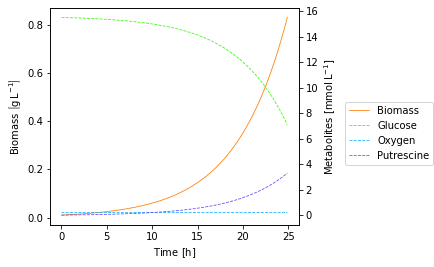

In [32]:
plot_concentrations(concentrations)

We see that glucose falls gradually while biomass is growing. Putrescine concentration is also growing over time. 

We plot the trajectories.

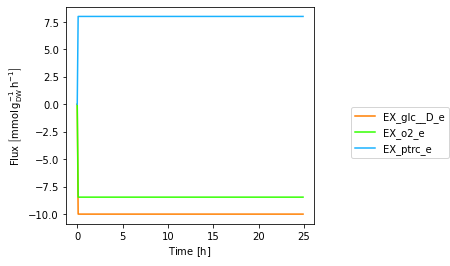

In [33]:
plot_trajectories(trajectories)

We see that the flux for putrescine increases at it is produced while oxygen and glucose falls. 